In [1]:
from datasets import DownloadManager

dl_manager = DownloadManager()
url = 'https://huggingface.co/datasets/jeremygf/domains-app-alpha/resolve/main/app.txt.gz'
file_path = dl_manager.download(url)

In [2]:
import pandas as pd

df = pd.read_csv(file_path, header=None, names=['text'], compression='gzip')
df['text'] = df['text'].astype(str)
df['text'].sample(5)

28548      tonaltherapy
61914     invoicesimple
312239         drinksdb
261182           lectia
337388           zentia
Name: text, dtype: object

Text(0.5, 0, 'Domain Length')

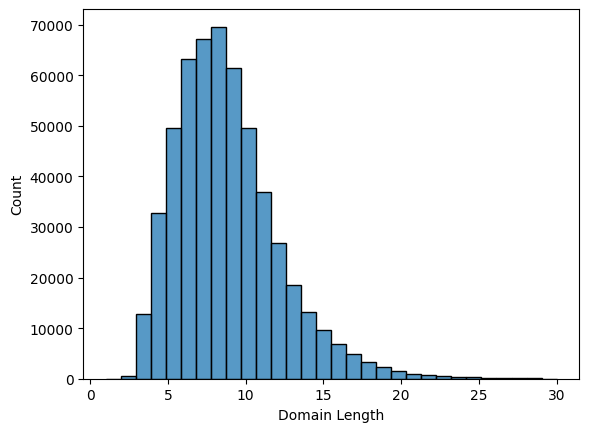

In [3]:
import seaborn as sns

df['length'] = df['text'].str.len()

g = sns.histplot(df['length'], bins=30)
g.set_xlabel('Domain Length')

In [4]:
class SpecialTokens:
    PAD = "[PAD]"
    START = "[STA]"
    END = "[END]"
    UNK = "[UNK]"
    TOKENS = [PAD, START, END, UNK]
    TUPLES = [(token, i) for i, token in enumerate(TOKENS)]

In [5]:
from tokenizers.trainers import BpeTrainer
from tokenizers import Tokenizer
from tokenizers.models import BPE

VOCAB_SIZE = 1000

trainer = BpeTrainer(
    special_tokens=SpecialTokens.TOKENS,
    vocab_size=VOCAB_SIZE
)

tokenizer = Tokenizer(BPE())

In [6]:
import gzip

with gzip.open(file_path, 'rt') as f:
    tokenizer.train_from_iterator(f, trainer=trainer)

In [7]:
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing

tokenizer.pre_tokenizer = Whitespace()
tokenizer.post_processor = TemplateProcessing(
    single="[STA] $A [END]",
    special_tokens=SpecialTokens.TUPLES,
)
tokenizer.enable_padding(pad_id=tokenizer.token_to_id(SpecialTokens.PAD))
tokenizer.save("tokenizer.json")

In [8]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(tokenizer_file='tokenizer.json')

In [9]:
from datasets import Dataset

ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['text', 'length'],
    num_rows: 534152
})

In [10]:
MAX_SEQ_LEN = 20

ds = ds.map(lambda x: {
    'ids': tokenizer.encode(
        text=x['text'],
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding='max_length'
    )
})

Map:   0%|          | 0/534152 [00:00<?, ? examples/s]

In [13]:
ds.push_to_hub("jeremygf/domains-app-alpha")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/535 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/jeremygf/domains-app-alpha/commit/4ee3ce49cfff4b92c149d0615db84d634284eea5', commit_message='Upload dataset', commit_description='', oid='4ee3ce49cfff4b92c149d0615db84d634284eea5', pr_url=None, pr_revision=None, pr_num=None)